# Tutorial #2 :: The Extended Kalman Filter
The Kalman filter (and the Extended Kalman Filter) is an incredibly powerful estimation technique. We will begin by describing the linear Kalman filter (this is what is meant when we say "Kalman filter" as opposed to "Extended" or "Unscented" Kalman filters), and then we'll show how this can be extended to nonlinear cases via the extended Kalman filter. 

The Kalman filter, though it does act as a filter, is most useful as a state estimation technique. In fact, given a linear system where the state variables are zero-mean and Gaussian distributed, the Kalman filter is an optimal estimator. We'll provide some rough math below to give some intuition into the code that will follow, but for a more complete understanding of Kalman filters and linear estimation in general, see *Adaptive Filters*, by Ali Sayed. 

Let's begin! 

## The Normal Equation for Optimal Linear Estimation
Linear estimation deals with estimating a random, possibly vector-valued variable $x$ given observations $y$. By default, we assume a vector-valued quantity is a column vector. Traditionally, these estimators are designed to be optimal in the *least squares sense*. In other words, they aim to minimize the square of the error

<center>$\tilde{x} = x - \hat{x}$</center>

where $\hat{x}$ is the estimate of vector $x$. The *mean-squared-error* or MSE of $\tilde{x}$ is given as $\mathbb{E}(\tilde{x}^2)$. One intuitive way of reasoning about $\hat{x}$ is that it must be constructed in such a way that $\tilde{x}$ is uncorrelated with observations $y$ or any function thereof, say $f(y)$. If $\tilde{x}$ *was* correlated with $y$, then additional information could still be gleaned from $y$, indicating that $\hat{x}$ is suboptimal. More formally, the following condition must hold:

<center>
$\tilde{x} \perp f(y) = \hat{x}$
</center>

using the simple observation that $\hat{x}$ is a function of $y$. This is commonly stated as the *orthognality principle*, because it implies that $\mathbb{E}\tilde{x}f(y)^* = 0$ for complex valued $x$ and $y$, or simply $\mathbb{E}\tilde{x}f(y)^T = 0$ for real values. Finally, it can be derived from probability that the optimal estimate of $\hat{x} = f(y)$ given observations $y$ is the conditional expectation

<center> $\hat{x} = \mathbb{E}(x~|~y)$ </center>

Linear estimation limits $f(y)$ to be a linear function, namely

<center> $f(y) = Ky + b$ </center>

for matrix $K$ and vector $b$. More specifically, we often assume zero-mean random variables $x$ and $y$ such that $\hat{x} = f(y) = Ky$. Given the orthogonality principle, the following must hold for an optimal estimator, denoted $K_o$:

<center>
$\begin{align}
\mathbb{E}(\tilde{x}y^T) &= 0\\
\mathbb{E}((x - K_oy)y^T) &= 0\\
\mathbb{E}(xy^T) - K_o\mathbb{E}(yy^T) &= 0\\
\end{align}$
</center>

or, more compactly,

<center>
$K_oR_y = R_{xy}$
</center>

where $R_{xy}$ represents the covariance matrix corresponding to random variables $x$ and $y$. The above equation is often referred to as the normal equation for optimal linear estimation. In summary, an optimal linear estimator $K_o$ is any such matrix that satisfies $K_o = R_y^{-1}R_{xy}$. We will not use these equations to directly derive the Kalman filter, but this provides great intuition into why we will see heavy use of covariance terms when *designing* our Kalman filters.

## Introducing the Linear Kalman Filter
We know from the previous section that we're seeking an optimal estimator $K_o$ such that $\hat{x} = K_oy$, where $K_oRy = R_{xy}$.

Now we're going to consider a transformation on $y$ into a new variable $e$:

<center>
$e = Ay$
</center>

for a lower triangular and invertible matrix $A$. The key is that we want each subsequent entry in the vector $e$ to be uncorrelated with the previous entry. In other words, we want to extract from $y$ the key information from all observations, ignoring any cross-correlation. These are called *innovations* of $y$. In other words, we want $R_e$ to be diagonal. 

We are now concerned with estimating $x$ from $e$: $\hat{x}_{|e} = R_{xe}R_e^{-1}e$. In fact, we can show algebraically that the estimators are equivalent--that is, estimating $\hat{x}$ from $e$ is the same as estimating $\hat{x}$ from $y$, but now $R_e$ is block diagonal, meaning it can be split nicely into a sum of individual estimators! In fact, we can write the following iterative formula:

<center>
$\begin{align}
\hat{x}_{|N} &= \hat{x}_{|N-1} + \hat{x}_{e_N}\\
&= \hat{x}_{|N-1} + (\mathbb{E}xe^T_N)R_{e,N}^{-1}e_N
\end{align}$
</center>

where $\hat{x}_{|N}$ denotes the estimate of $x$ using only up to $N$ observations $y$. At this point we have an iterative, causal way of estimating $\hat{x}$, but we haven't yet explained how to get the innovations $e$ from $y$--we've just assumed they exist. In fact, we can construct each innovation $e_i$ by *whitening* the observations $y$: $e_i = y_i - \hat{y}_{i|i-1}$. We'll not dig into the details here, referring the reader again to *Adaptive Filters* by Sayed. 

## State-Space Models
In order to understand Kalman filters, we must first understand state-space representations. State-space models describe the iterative progression of the state, $x$, as well as the observations $y$ as a function of the state. Specifcally, we often write

<center>
$\begin{align}
x_{k+1} &= F_kx_k + B_ku_k + w_k \\
z_{k} &= H_kx_k + v_k
\end{align}$
</center>

where $k$ is the discrete time index, $u$ is the input to the system, and $F$, $B$, and $H$ describe the evolution of the state and the observations--these depend on the physics of the system and the sensors used. Note that the matrices themselves *can* vary with time as well, although they certainly don't have to. Finally, $w_k$ and $v_k$ *should* be zero-mean and white for optimal performance. 

## The Kalman Filter Equations
Here we skip forward *a lot* in the derivation of the Kalman filter, skipping straight to the recursion equations themselves. I hope to fill this material in later, but for now the reader will have to take these equations on faith. 

Given a linear model described in state-space format, and given state variables $x$ and observations $y$ as discussed, the Kalman filter recursion is as folllows, adopting the notation used by Wikipedia:

We begin with a prediction stage:

<center>
$\begin{align}
\hat{x}_{k|k-1} &= F_k\hat{x}_{k-1|k-1} + B_ku_k \\
P_{k|k-1} &= F_kP_{k-1|k-1}F_k^T + Q_k
\end{align}$
</center>

where $P_k$ is the state covariance matrix and $Q_k$ is the process covariance matrix. $P_k$ describes the current uncertainty of any of the given state variables at time $k$ as well as their cross-covariance terms with regard to other state variables. Small elements of $P_k$ indicate accurate state variable estimates. $Q_k$ is often a diagonal matrix whose elements dictate the variance in the process itself--.e.g how much you predict a device's position may vary in a manner uncaptured by your state model. 

Next we have an update stage:
<center>
$\begin{align}
\tilde{y}_k &= z_k - H_k\hat{x}_{k|k-1}\\
S_k &= H_kP_{k|k-1}H_k^T + R_k \\
K_k &= P_{k|k-1}H_k^TS_k^{-1} \\
\hat{x}_{k|k} &= \hat{x}_{k|k-1} + K_k\tilde{y}_k \\
P_{k|k} &= (I - K_kH_k)P_{k|k-1}
\end{align}$
</center>

where $S_k$ is the covariance matrix of the innovation terms, $e$, and $K_k$ is called the Kalman *gain* and dictates how the state is advanced as a function of each prediction.  

These equations are set in stone, so as a designer what must you decide upon for your application-specific Kalman filter? A designer must do the following:

1.  Decide the variances embedded in the measurement covariance matrix $R$
2.  Decide the variances embedded in the process covariance matrix $Q$. 
3.  Design the state transition matrix $F$, any feed forward matrix $B$ (often zero), and the measurement matrix $H$. 
4. Decide on the initial uncertainty of all state variables, $P_{k=0}$ as well as the initial state estimate itself, $x_{k=0}$. 

The problem is that the system is not often linear, and even if it *is* designing the linear matrices to best represent the dynamics of your system can be difficult.  Enter the Extended Kalman Filter, or EKF. 

## The Extended Kalman Filter
The Extended Kalman Filter (EKF) does not benefit from the same optimality guarantees that the linear Kalman filter does--that is, it's not provably optimal, or at least has yet to be proven optimal. Nevertheless, it is an incredibly powerful tool that performs admirably even with nonlinear systems.  Just because we have yet to *prove* that it's optimal should not dissuade you from using it!

The key idea is very simple--we take the same Kalman filter equations, but where we require linear dynamic matrices such as $F$ and $K$ we instead *create* these matrices by linearizing about the current state estimate. In fact, we can write our code such that we need only provide function handles to our EKF rather than a matrix at all! This undoubtedly adds to computation time, but it can be very convenient for quickly designing very powerful state estimation code. 

Rather than re-write the Kalman filter equations here, we will instead write the EKF as pseudocode, where it is assumed that matrix multiplication is allowed. First, the developer must design a process and a measurement function:

`fstate` predicts the next state from the current state. For example, you might predict the future position of an object based on its current position and its current velocity.

`fmeas` predicts the observation vector $z$ based on the current state estimate. For example, you might have a measurement that consists of the distance between two objects, both who have positions tracked in your state vector. You can predict this range based on your current estimate of their two positions. 

The EKF equations can then be written as follows.

```
[x1,A]=linearize(fstate,x);   
P=A*P*A'+Q;                
[z1,H]=linearize(fmeas,x1);    
P12=P*H';                   
K=P12*inv(H*P12+R);      
x=x1+K*(z-z1);           
P=P-K*P12';             
```

the `linearize` function can be done a number of ways. One generalizable way uses the addition of *very* small complex numbers to evaluate the gradient (i.e. find the Jacobian) of a function with respect to a given state, $x$. 

```
% Linearization through complex step differentiation
function [z,A]=linearize(fcn,x)
    z=fcn(x);
    n=length(x);
    m=length(z);
    A=zeros(m,n);
    h=n*eps;
    for k=1 to n
        x1=x;
        x1(k)=x1(k)+h*i;
        A(:,k)=imag(fun(x1))/h;
    end
```

where `eps` is a very small number, $i = \sqrt{-1}$, and `imag` extracts the imaginary component of a complex number. 

## An Example of the EKF in Action
First, let's define a couple of functions to help us with our EKF estimation filter, as per the pseudocode written above, which was largely adopting Matlab's syntax.


In [1]:
import numpy as np
import scipy.linalg

def ekfUpdate(fcn_state,x,P,fcn_meas,z,Q,R):
    x1,A = linearize(fcn_state, x)
    P = A*P*A.T + Q
    z1,H = linearize(fcn_meas, x1)
    P12 = P*H.T
    R = scipy.linalg.cholesky( H*P12 + R )
    U = P12*np.linalg.pinv(R)
    dz = (z-z1)
    x = x1 +  U * np.linalg.pinv(R.T)*dz
    P = P - U*U.T
    return (x, P)

def linearize(fcn, x):
    z = fcn(x)
    n = len(x)
    m = len(z)
    A = np.mat( np.zeros( (m,n) ) )
    h = n*np.spacing(1)
    for k in range(n):
        x1 = np.matrix(x, dtype='complex')
        x1[k] += h*1j
        A[:,k] = fcn(x1).imag / h
    return (z, A)

Now let's just do a very simple (simulated) example--we'll pretend we'd like to track the velocity of an object, and our only estimate is a noisy 2D position measurement (e.g. GPS). This is a very simple state and mesurement equation, and in fact can very easily be done with **linear** equations and a standard Kalman Filter. However, we're using it here just to demonstrate the general ideas behind Kalman filters as well as the effect of changing the various covariance terms.

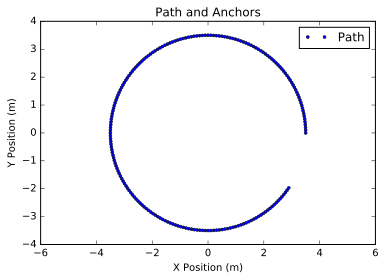

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# First, some Jupyter plotting config
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

# environment
BOUNDX = [-5,5]
BOUNDY = [-5,5]
# Path shape and speed
PATHRAD = 3.5
PATHVEL = 1.0
# timing
TSTOP = 20
TSTEP = (1.0/10)

# true path
times = np.arange(TSTOP, step=TSTEP)
path_angle = times*(PATHVEL/PATHRAD)
path_x = np.cos(path_angle)*PATHRAD
path_y = np.sin(path_angle)*PATHRAD
path_xy = np.stack([path_x,path_y], axis=1)
path_vel = np.array([0,0])
for i in range(1,len(path_xy)):
    dx = path_xy[i,0] - path_xy[i-1,0]
    dy = path_xy[i,1] - path_xy[i-1,1]
    path_vel = np.vstack([path_vel, [dx/TSTEP, dy/TSTEP]])

# Plot path
plt.plot(path_xy[:,0], path_xy[:,1], 'bo', markersize=3)  

plt.title('Path and Anchors')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.legend(['Path'])
plt.show()

In [3]:
def fcn_state(state, delta_t):
    x = state.item(0)
    y = state.item(1)
    vx = state.item(2)
    vy = state.item(3)
    
    s = np.array([
            # predicted position
            [x + delta_t*vx],
            [y + delta_t*vy],
            # velocity is predicted to not change
            [vx],
            [vy],
        ])

    return s

For measurements, we will only have noisy measurements of x and y.

In [4]:
def fcn_meas(state):
    x = state.item(0)
    y = state.item(1)
    vx = state.item(2)
    vy = state.item(3)
    
    # creating our predicted measurement matrix
    z = np.matrix([
            [x],
            [y],
        ])
    
    return z

So we've related the next state to the current state and we've estimated the observations we should see at some time in the future based on the current state. Both of these will, in conjunction with our covariance matrices, attempt to drive the state etimate to something sensible.

Let's tie it all together now with inital estimates as well as our covariance terms for both our process noise and our measurement noise.

In [5]:
import numpy as np

# initialize state
state_init = np.matrix([
        # position
        [0], [0],
        # velocity
        [0], [0]
    ])

# initial state uncertainties
init_cov_pos = 5.0
init_cov_vel = 2.0
P_init = np.diag( [
        init_cov_pos, init_cov_pos, init_cov_vel, init_cov_vel
    ])

# process covariances
cov_pos = 0.50
cov_vel = 0.50
Q = np.diag( [
        cov_pos, cov_pos, cov_vel, cov_vel
    ])

# measurement covariances
cov_meas_pos = 2.0
R = np.diag( [
        cov_meas_pos, cov_meas_pos,
    ])


The process covariance dictates how much we expect our state variables to vary in a *valid* manner--e.g. how much we might reasonably expect the position to vary on a per-second basis. The measurement covariance dictates how much we can trust each measurement---the more variance, the less trustworthy. 

Now all that is left is to loop over our simulated measurements and make calls to the EKF functions we defined earlier, which we'll do now.


In [6]:
# measurement noise
POS_MEAS_NOISE = 0.25

# some variables we'll need
state = state_init
P = P_init
time = 0
k = 0
t_last = times[k]

# track our estimates, so we can plot them
pos_measurements = np.array([]).reshape(0,2)
pos_estimates = np.array([]).reshape(0,2)
vel_estimates = np.array([]).reshape(0,2)

for k in range(1,len(times)):

    # True position
    xy_tru = path_xy[k,:]
    
    # make noisy measurements
    meas_x = xy_tru.item(0) + POS_MEAS_NOISE*np.random.randn()
    meas_y = xy_tru.item(1) + POS_MEAS_NOISE*np.random.randn()
    pos_measurements = np.vstack([pos_measurements, [meas_x,meas_y]])
    
    # get measurement vector
    z = np.matrix([
            [meas_x],
            [meas_y],
        ])
    
    # time change
    dt = times[k] - t_last
    t_last = times[k]
    
    # forward propagation of state using rate gyros
    fcn_state_bound = lambda s: fcn_state(s, dt)
    
    # kalman filter update
    state, P = ekfUpdate(fcn_state_bound, state, P, fcn_meas, z, dt*Q, R)

    pos_estimates = np.vstack([pos_estimates, [state.item(0), state.item(1)]])
    vel_estimates = np.vstack([vel_estimates, [state.item(2), state.item(3)]])

    
print('Measurement time elapsed:', np.round(t_last - times[0]), 'sec.')

('Measurement time elapsed:', 20.0, 'sec.')


And we're done! Let's plot the x and y coordinates from above so that we can see how closely we matched up with the earlier plot showing true path.

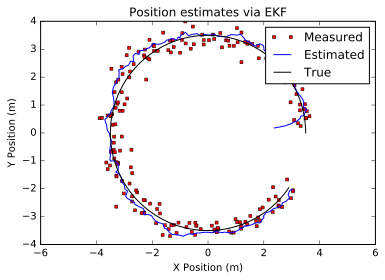

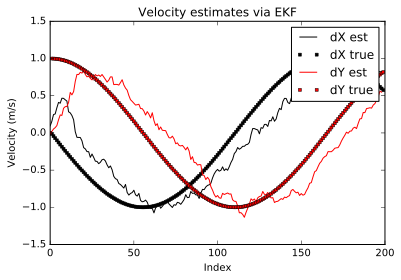

In [7]:
# Plot position estimates
plt.plot(pos_measurements[:,0], pos_measurements[:,1], 'rs', markersize=3) 
plt.plot(pos_estimates[:,0], pos_estimates[:,1], 'b-') 
plt.plot(path_xy[:,0], path_xy[:,1], 'k-') 
plt.title('Position estimates via EKF')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend(['Measured','Estimated', 'True'])
plt.axis('equal')
plt.show()

# Plot velocity estimates
plt.plot(vel_estimates[:,0], 'k-') 
plt.plot(path_vel[:,0], 'ks', markersize=3)
plt.plot(vel_estimates[:,1], 'r-') 
plt.plot(path_vel[:,1], 'rs', markersize=3)
plt.title('Velocity estimates via EKF')
plt.xlabel('Index')
plt.ylabel('Velocity (m/s)')
plt.legend(['dX est','dX true','dY est','dY true'])
plt.show()


So our position estimate is Okay--it definitely tracks the true circular path, but it's not much better than a running average of our position estimates.  More importantly, however, is the fact that the velocity is offset. This happens because our process model isn't very good for this experiment. We've naively predicted that the velocities remain the same, when in fact they are *constantly* changing--it was a terrible assumption. We even know *how* the velocities are changing--they are sinusoidal. Let's improve that a bit by assuming that there is a constant **angular velocity** as opposed to constant linear velocities. A better system model will undoubtedly lead to a better state estimate. 

In [8]:
def fcn_state(state, delta_t):
    x = state.item(0)
    y = state.item(1)
    theta = state.item(2)
    dtheta = state.item(3)
    
    # path radius / vector norm
    radius = np.linalg.norm([x,y])
    
    s = np.array([
            # predicted position
            [radius*np.cos(theta + dtheta*delta_t)],
            [radius*np.sin(theta + dtheta*delta_t)],
            # new angle
            [theta + dtheta*delta_t],
            # constant ANGULAR velocity
            [dtheta],
        ])

    return s

def fcn_meas(state):
    x = state.item(0)
    y = state.item(1)
    
    # creating our predicted measurement matrix
    z = np.matrix([
            [x],
            [y],
        ])
    
    return z

import numpy as np

# initialize state
state_init = np.matrix([
        # position
        [0], [0],
        # angle and angular velocity
        [0], [0]
    ])

# initial state uncertainties
init_cov_pos = 5.0
init_cov_ang = np.pi/2
init_cov_vel = 5.0
P_init = np.diag( [
        init_cov_pos, init_cov_pos, init_cov_ang, init_cov_vel
    ])

# process covariances
cov_pos = 2.0
cov_ang = np.pi/4
cov_vel = 0.0
Q = np.diag( [
        cov_pos, cov_pos, cov_ang, cov_vel
    ])

In [9]:
# measurement noise
POS_MEAS_NOISE = 0.25

# some variables we'll need
state = state_init
P = P_init
time = 0
k = 0
t_last = times[k]

# track our estimates, so we can plot them
pos_measurements = np.array([]).reshape(0,2)
pos_estimates = np.array([]).reshape(0,2)
vel_estimates = np.array([]).reshape(0,1)
vel_covariances = np.array([]).reshape(0,1)
tstamps = np.array([]).reshape(0,1)

for k in range(1,len(times)):

    # True position
    xy_tru = path_xy[k,:]
    
    # make noisy measurements
    meas_x = xy_tru.item(0) + POS_MEAS_NOISE*np.random.randn()
    meas_y = xy_tru.item(1) + POS_MEAS_NOISE*np.random.randn()
    pos_measurements = np.vstack([pos_measurements, [meas_x,meas_y]])
    
    # get measurement vector
    z = np.matrix([
            [meas_x],
            [meas_y],
        ])
    
    # time change
    dt = times[k] - t_last
    t_last = times[k]
    tstamps = np.vstack([tstamps, [t_last]])
    
    # forward propagation of state using rate gyros
    fcn_state_bound = lambda s: fcn_state(s, dt)
    
    # kalman filter update
    state, P = ekfUpdate(fcn_state_bound, state, P, fcn_meas, z, dt*Q, R)

    pos_estimates = np.vstack([pos_estimates, [state.item(0), state.item(1)]])
    vel_estimates = np.vstack([vel_estimates, [state.item(3)]])
    vel_covariances = np.vstack([vel_covariances, P[3,3]])
    
print('Measurement time elapsed:', np.round(t_last - times[0]), 'sec.')

('Measurement time elapsed:', 20.0, 'sec.')


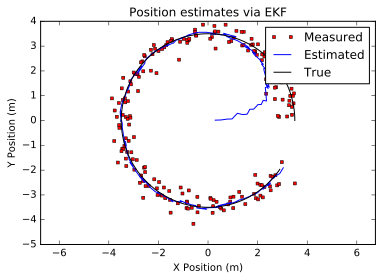

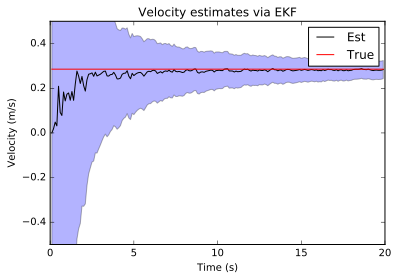

In [10]:
# Plot position estimates
plt.plot(pos_measurements[:,0], pos_measurements[:,1], 'rs', markersize=3) 
plt.plot(pos_estimates[:,0], pos_estimates[:,1], 'b-') 
plt.plot(path_xy[:,0], path_xy[:,1], 'k-') 
plt.title('Position estimates via EKF')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend(['Measured','Estimated', 'True'])
plt.axis('equal')
plt.show()

# Plot velocity estimates
plt.plot(tstamps,vel_estimates, 'k-') 
plt.plot(tstamps,np.ones(len(times[1:]))*PATHVEL/PATHRAD, 'r-', markersize=3)
plt.fill_between(tstamps[:,0], vel_estimates[:,0]-vel_covariances[:,0], \
                 vel_estimates[:,0]+vel_covariances[:,0], alpha='0.3')
plt.title('Velocity estimates via EKF')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend(['Est','True'])
plt.ylim([-0.5,0.5])
plt.show()

That's *much* better--it pays to have a good dynamic model!